In [1]:
!pip install lightfm implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 27.1 MB/s eta 0:00:00
  Created wheel for lightfm: filename=lightfm-1.17-cp39-cp39-linux_x86_64.whl size=889392 sha256=ea8f5192903fe6bcd2aa9dd0618a5d4017e0e98039a77e4e1b80fe8c2abd3f24
  Stored in directory: /root/.cache/pip/wheels/d8/65/93/6ac8180274dc2e8f86ff326be62da1dfa55dc158fd45faba7d
Successfully built lightfm


In [2]:
import pandas as pd
import numpy as np

import datetime 
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from xgboost import XGBClassifier
from sklearn import metrics

from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from lightfm import LightFM
from scipy.sparse import coo_matrix
import scipy.sparse as sparse
from sklearn import preprocessing

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Функции

In [4]:
# Случайная неполная выборка (нахождение класса большинства и его неполная выборка)
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1


def create_dataframe(visitor): 

    visitor_df_array = []

    for x in visitor:

        #Создание массива, содержащего все данные о посетителе, кроме id
        v_df = data[data.visitorid == x]
        #Создание временного массива для хранения всех атрибутов посетителей
        temp = []
        #Заполнение первого элемента массива текущим индексом
        temp.append(x)
        #Заполнение массива количеством уникальных товаров, просмотренных посетителем (num_uniq_items_viewed)
        temp.append(v_df[v_df.event == 'view'].itemid.unique().size)
        # Заполнение массива количеством просмотров товаров посетителем независимо от того, тот же это продукт или нет (num_views_total)
        temp.append(v_df[v_df.event == 'view'].event.count())
        number_of_items_bought = v_df[v_df.event == 'transaction'].event.count()
        temp.append(number_of_items_bought)
       
        # если посетитель купил хотя бы 1 товар, атрибуту присваивается значение 1, если посетитель ничего не купил, присваивается значение 0
        if(number_of_items_bought == 0):
            temp.append(0)
        else:
            temp.append(1)

        visitor_df_array.append(temp)

    return pd.DataFrame(visitor_df_array, columns=['visitorid', 'num_uniq_items_viewed', 'num_views_total', 'bought_count', 'purchased'])

In [5]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Diploma/SkillFactory_Diploma/data.csv')

In [6]:
need_cols =  ['timestamp', 'itemid', 'visitorid', 'event']
df = data[need_cols]

In [7]:
train = data[pd.to_datetime(df['timestamp'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
test = data[pd.to_datetime(df['timestamp'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

# XGBoost

XGBoost (Extreme Gradient Boosting, экстремальный градиентный бустинг) — это эффективная опенсорсная реализация алгоритма градиентного бустинга. Этот фреймворк отличается высокой скоростью работы, а модели, построенные на его основе, обладают хорошей производительностью. Поэтому он пользуется популярностью при решении задач классификации и регрессии с использованием табличных наборов данных. 

Для решения задачи классификации добавим в наши данные таргет - 1 при наличии тразакции и 0, если транзакции не было.

In [8]:
train['target'] = train['event'].apply(lambda x: 1 if  x=='transaction' else 0)
test['target'] = test['event'].apply(lambda x: 1 if  x=='transaction' else 0)

In [9]:
cat_features = ['visitorid', 'itemid', 'day_of_week',
       'Month', 'Day', 'Hour', 'minute', 'target']

In [10]:
train = random_under(train, 'target')

Class 0: 17455
Class 1: 17455
Proportion: 1 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

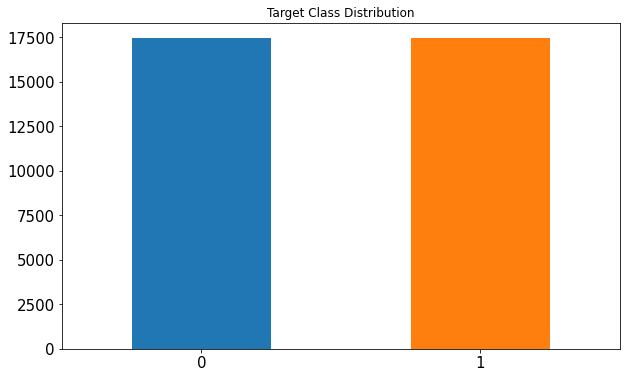

In [11]:
fig = plt.figure(figsize = (10,6))
new_target_count = train['target'].value_counts()
print('Class 0:', new_target_count[0])
print('Class 1:', new_target_count[1])
print('Proportion:', int(round(new_target_count[0] / new_target_count[1])), ': 1')
new_target_count.plot(kind='bar', title='Target Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

In [12]:
X_train = train[['visitorid', 'itemid', 'day_of_week','Month', 'Day', 'Hour', 'minute']]
X_test = test[['visitorid', 'itemid', 'day_of_week','Month', 'Day', 'Hour', 'minute']]
y_train = train['target']
y_test = test['target']

In [13]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
preds = xgb.predict(X_test)

In [15]:
print('precision_score = {:7.4f}'.format(metrics.precision_score(y_test, preds)))
print('recall_score = {:7.4f}'.format(metrics.recall_score(y_test, preds)))
print('f1_score = {:7.4f}'.format(metrics.f1_score(y_test, preds)))
print('accuracy = {:7.4f}'.format(metrics.accuracy_score(y_test, preds)))

precision_score =  0.0115
recall_score =  0.4668
f1_score =  0.0224
accuracy =  0.6635


Даже несмотря на то, что мы попытались уровнять классы, значение метрик получилось не очень высоким. Возможно обогащение датасета, даст лучшие результаты.

# Коллаборативная фильтрация

**Коллаборативная фильтрация**, совместная фильтрация (англ. collaborative filtering) — это один из методов построения прогнозов (рекомендаций) в рекомендательных системах, использующий известные предпочтения (оценки) группы пользователей для прогнозирования неизвестных предпочтений другого пользователя.Его основное допущение состоит в следующем: те, кто одинаково оценивал какие-либо предметы в прошлом, склонны давать похожие оценки другим предметам и в будущем.Например, с помощью коллаборативной фильтрации музыкальное приложение способно прогнозировать, какая музыка понравится пользователю, имея неполный список его предпочтений (симпатий и антипатий).Прогнозы составляются индивидуально для каждого пользователя, хотя используемая информация собрана от многих участников. Тем самым коллаборативная фильтрация отличается от более простого подхода, дающего усреднённую оценку для каждого объекта интереса, к примеру, базирующуюся на количестве поданных за него голосов.

Составим список всех идентификаторов клиентов.

In [16]:
all_visitors = data.visitorid.sort_values().unique() 
all_visitors.size

1407580

Теперь составим список клиентов, которые что-то купили.

In [17]:
buy_visitors = data[data.event == 'transaction'].visitorid.sort_values().unique()
buy_visitors.size 

11719

Cоздание массива, который получает идентификаторы посетителей, у которых не было события транзакции.

In [18]:
view_visitors = list([x for x in all_visitors if x not in buy_visitors])

In [19]:
buy_visitors_df = create_dataframe(buy_visitors)

In [20]:
buy_visitors_df.head(3)

,visitorid,num_uniq_items_viewed,num_views_total,bought_count,purchased
0,172,22,33,2,1
1,186,1,2,1,1
2,264,2,3,2,1


In [21]:
trainCF = data[pd.to_datetime(data['timestamp'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testCF = data[pd.to_datetime(data['timestamp'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

Сначала мы создаем список, который содержит заказы клиентов и элементы внутри них.

In [22]:
purchased_items = []
    
for customer in buy_visitors:
    purchased_items.append(list(data.loc[(data.visitorid == customer) & (data.transactionid.notnull())].itemid.values))  

Напишем функцию, которая выдавала бы список товаров, которые были куплены вместе с указанным товаром.

In [23]:
def recommender_bought_bought(item_id, purchased_items):
    
    # Perhaps implement a binary search for that item id in the list of arrays
    # Then put the arrays containing that item id in a new list
    # Then merge all items in that list and get rid of duplicates
    recommender_list = []
    for x in purchased_items:
        if item_id in x:
            recommender_list += x
    
    #Then merge recommender list and remove the item id
    recommender_list = list(set(recommender_list) - set([item_id]))
    
    return recommender_list

Напишем функцию расчета метрики.

In [24]:
def metrik_p3(df): 
  res = len(set(top3) & set(df))
  p_3= round((res/3),2)  
  return p_3

Если мы введем здесь идентификатор элемента, мы получим список элементов, которые появились в заказах с указанным элементом.

In [25]:
recommender_bought_bought(302422, purchased_items)[:3]

[105792, 200793, 12836]

Выведем список ТОП-3 товаров.

In [26]:
top3 = list(train.itemid.value_counts()[:3].index)
top3

[461686, 119736, 213834]

Рассчитаем нашу метрику на 30 произвольных записи из тестовой части.

In [27]:
test_sample = testCF[testCF['event']=='transaction'].sample(n=30)

In [28]:
test_sample.head(3)

,Unnamed: 0,timestamp,visitorid,event,itemid,transactionid,event_datetime,freq,day_of_week,Year,Month,Day,Hour,minute,Day Period
2742780,1447357,1442439220650,294308,transaction,264379,2814.0,2015-09-16 21:33:40.650,6,2,2015,9,16,21,33,Evening
2517695,1220116,1441391397736,341443,transaction,403996,12751.0,2015-09-04 18:29:57.736,13,4,2015,9,4,18,29,Evening
2199022,897217,1439853703811,143811,transaction,193272,12182.0,2015-08-17 23:21:43.811,3,0,2015,8,17,23,21,Night


In [29]:
test_sample['1'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[0:1])
test_sample['2'] = test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[1:2])
test_sample['3'] =test_sample['itemid'].apply(lambda row: recommender_bought_bought(row, purchased_items)[2:3])

In [30]:
def replace_col(df):
  df =  df.apply(lambda x: str(x).replace('[', ''))
  df =  df.apply(lambda x: str(x).replace(']', ''))
  return df

In [31]:
test_sample['1'] =  replace_col(test_sample['1'])
test_sample['2'] =  replace_col(test_sample['2'])
test_sample['3'] =  replace_col(test_sample['3'])
test_sample['1'] = test_sample['1'].apply(lambda x: top3[0] if x=='' else x)
test_sample['2'] = test_sample['2'].apply(lambda x: top3[1] if x=='' else x)
test_sample['3'] = test_sample['3'].apply(lambda x: top3[2] if x=='' else x)

In [32]:
test_sample['pred'] = test_sample[['1', '2', '3']].values.tolist()

In [33]:
test_sample['p@3'] = 0

In [34]:
index = test_sample.pred.index
for i in index:
  test_sample['p@3'][i] = metrik_p3(test_sample['pred'][i])

In [35]:
test_sample.head(3)

,Unnamed: 0,timestamp,visitorid,event,itemid,transactionid,event_datetime,freq,day_of_week,Year,Month,Day,Hour,minute,Day Period,1,2,3,pred,p@3
2742780,1447357,1442439220650,294308,transaction,264379,2814.0,2015-09-16 21:33:40.650,6,2,2015,9,16,21,33,Evening,21757,119736,213834,"[21757, 119736, 213834]",0.67
2517695,1220116,1441391397736,341443,transaction,403996,12751.0,2015-09-04 18:29:57.736,13,4,2015,9,4,18,29,Evening,56810,169397,213834,"[56810, 169397, 213834]",0.33
2199022,897217,1439853703811,143811,transaction,193272,12182.0,2015-08-17 23:21:43.811,3,0,2015,8,17,23,21,Night,461686,119736,213834,"[461686, 119736, 213834]",1.00


In [36]:
# Precision@3
metric = round(test_sample['p@3'].mean(),2)
print('Mean Average Precision at 3: {:.2}'.format(metric))

Mean Average Precision at 3: 0.28


# ALS

Задача факторизационных машин близка к матричной факторизации, но теперь каждая запись обучающего датасета — это факторы user, факторы item и факторы их взаимосвязи.

Чтобы разработать нашу модель, нам сначала нужно вычислить баллы для каждого типа событий, наблюдаемых в нашем наборе данных. Поскольку распределения событий показывают насколько редки транзакции, мы должны дать им гораздо более высокий балл, чем view и addtocart, а addtocart также должен иметь другой балл, который представляет их вес в распределении.

In [37]:
dfALS = data.copy()

In [38]:
dfALS['event_scores'] = dfALS['event'].apply(
    lambda x: 1 if x == 'view' else 5 if x == 'addtocart' else 25 if x == 'transaction' else 0
)

In [39]:
dfALS.head(3)

,Unnamed: 0,timestamp,visitorid,event,itemid,transactionid,event_datetime,freq,day_of_week,Year,Month,Day,Hour,minute,Day Period,event_scores
0,1462974,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,3,6,2015,5,3,3,0,Dawn,5
1,1464806,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,1,6,2015,5,3,3,0,Dawn,1
2,1463000,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,1,6,2015,5,3,3,0,Dawn,1


Далее мы закодируем наши столбцы идентификаторов, чтобы преобразовать их в разреженную матрицу для экономии места и чтобы наша модель была способна вычислять все возможные взаимодействия в наборе данных. Это достаточно просто благодаря модулю scipy.sparse.

In [40]:
dfALS['visitorid'] = dfALS['visitorid'].astype("category").cat.as_ordered()
dfALS['itemid'] = dfALS['itemid'].astype("category").cat.as_ordered()

sparse_item_user = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['itemid'], dfALS['visitorid'])))
sparse_user_item = sparse.csr_matrix((dfALS['event_scores'].astype(float), (dfALS['visitorid'], dfALS['itemid'])))

In [41]:
trainALS = dfALS[pd.to_datetime(dfALS['timestamp'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testALS = dfALS[pd.to_datetime(dfALS['timestamp'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [42]:
trainALS['visitorid'] = trainALS['visitorid'].astype("category").cat.as_ordered()
trainALS['itemid'] = trainALS['itemid'].astype("category").cat.as_ordered()

testALS['visitorid'] = testALS['visitorid'].astype("category").cat.as_ordered()
testALS['itemid'] = testALS['itemid'].astype("category").cat.as_ordered()

In [43]:
sparse_train_item_user = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['itemid'], trainALS['visitorid'])))
sparse_train_user_item = sparse.csr_matrix((trainALS['event_scores'].astype(float), (trainALS['visitorid'], trainALS['itemid'])))

In [44]:
sparse_test_item_user = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['itemid'], testALS['visitorid'])))
sparse_test_user_item = sparse.csr_matrix((testALS['event_scores'].astype(float), (testALS['visitorid'], testALS['itemid'])))

Как только наши матрицы готовы, мы можем параметризовать и подогнать нашу модель.

Используемые параметры являются довольно стандартными: латентные_факторы и n_iter параметры, которые изменяются чаще, поскольку их увеличение увеличило бы прогностическую силу нашей модели за счет более высоких вычислений, использования памяти и вероятности переобучения для нашей оценки.

Параметр альфа также важен, так как он соответствует
параметр метода ALS, который преобразует нашу матрицу событий в матрицу достоверности. Этот параметр не должен сильно меняться по сравнению с количеством эпох или вложений, хотя разумной альтернативой для аналогичной задачи могло бы быть 15, что было исходным значением статьи.

In [45]:
latent_factors = 20
regularization = 0.1
n_iter = 20
alpha = 40

conf_matrix = (sparse_train_item_user * alpha).astype('double')

model = AlternatingLeastSquares(
    factors=latent_factors,
    regularization=regularization,
    iterations=n_iter
)

model.fit(conf_matrix)

  0%|          | 0/20 [00:00<?, ?it/s]

In [46]:
p_at3_als = mean_average_precision_at_k(model, sparse_train_item_user, sparse_test_item_user, K=3)
print('Mean Average Precision at 3: {:.2%}'.format(p_at3_als))

  0%|          | 0/119873 [00:00<?, ?it/s]

Mean Average Precision at 3: 0.13%


In [47]:
def recommend_item_to_user(model, visitorid, sparse_test_item_user, n=3):
    recommended = model.recommend(visitorid, sparse_test_item_user[visitorid], n)
    return recommended


def similar_items_to_item(model, itemid, n=3):
    similar = model.similar_items(itemid, n)
    return similar

In [48]:
userid = 97154
recommended_items = recommend_item_to_user(model, userid, sparse_test_item_user)
print(f"Recommended items for user {userid}:\n{recommended_items[0]}")

Recommended items for user 97154:
[1134975  836635  518659]


In [49]:
itemid = 350566
similar_items = similar_items_to_item(model, itemid)
print(f"Similar items to {itemid}:\n{similar_items[0]}")

Similar items to 350566:
[350566 103940 390643]


# LightFM

LightFM — это реализация на Python ряда популярных алгоритмов рекомендаций как для неявной, так и для явной обратной связи.

Будем использовать lightfm не только из-за его гибридных возможностей, но и из-за того, что он позволяет использовать обычные взаимодействия пользователя с элементом для прогнозирования для известных пользователей. Это очень важно, поскольку у нас не было формальных рейтингов для элементов, мы все равно могли генерировать рекомендации на основе этих взаимодействий. Поскольку у нас есть только неявная обратная связь от пользователей, гибкость lightfm в этом отношении полезна.

In [50]:
from lightfm.evaluation import precision_at_k
from lightfm.data import Dataset

In [51]:
trainLFM = data[pd.to_datetime(data['timestamp'], unit='ms') < pd.Timestamp('2015-08-15 00:00:00.000000')]
testLFM = data[pd.to_datetime(data['timestamp'], unit='ms') >= pd.Timestamp('2015-08-15 00:00:00.000000')]

In [52]:
all_visitorids = data.visitorid.unique()
all_itemids = data.itemid.unique()

In [53]:
dataset = Dataset()

In [54]:
dataset.fit(users=all_visitorids, items=all_itemids)

In [55]:
train_coo = dataset.build_interactions(trainLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)

In [56]:
test_coo = dataset.build_interactions(testLFM.query('event =="transaction"')[['visitorid', 'itemid']].values)

In [57]:
modelLFM = LightFM(loss='warp', no_components=50, random_state=42)
modelLFM.fit(train_coo[0], epochs=20)

In [58]:
p_at3 = precision_at_k(modelLFM, test_coo[0], k=3).mean()
print('Mean Average Precision at 3: {:.2%}'.format(p_at3))

Mean Average Precision at 3: 0.74%


In [59]:
import numpy as np
scores = modelLFM.predict(1, np.arange(len(all_itemids)))
top = np.argsort(-scores)[:3]
item_lagels = {v:k for k, v in dataset.mapping()[2].items()}

In [60]:
[item_lagels[k] for k in top]

[461686, 7943, 48030]

In [61]:
#количество пользователей и товаров в обучающих данных
df = data[['itemid']]
items = df.to_numpy()

def sample_recommendation(model, data, user_ids):

    n_users, n_items = data.shape

    #generate recommendations for each user we input
    for user_id in user_ids:

        #movies our model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))

        #rank them in order of most liked to least
        top_items = items[np.argsort(-scores)][:3]

        print(top_items)

In [66]:
sample_recommendation(modelLFM, test_coo[0], [1])

[[424724]
 [444820]
 [108486]]


In [67]:
import pickle

In [69]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Diploma/SkillFactory_Diploma/lightfm_model.pickle', 'wb') as f:
    pickle.dump(modelLFM, f, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
visitors_items_mapping = dataset.mapping()

with open('/content/gdrive/MyDrive/Colab Notebooks/Diploma/SkillFactory_Diploma/lightfm_data_mapping.pickle', 'wb') as f:
    pickle.dump(visitors_items_mapping, f, protocol=pickle.HIGHEST_PROTOCOL)